In [73]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import hashlib
from sklearn.model_selection import StratifiedShuffleSplit



In [ ]:
#Load the relevant data into a dataframe
housing = pd.read_csv("housing.csv", thousands =',')

In [61]:
# summary analytics of the data
# percentile list
perc =[.20, .40, .60, .80]
  
# list of dtypes to include
include =['object', 'float', 'int']

desc_housing = housing.describe(percentiles = perc, include = include)

In [62]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [63]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

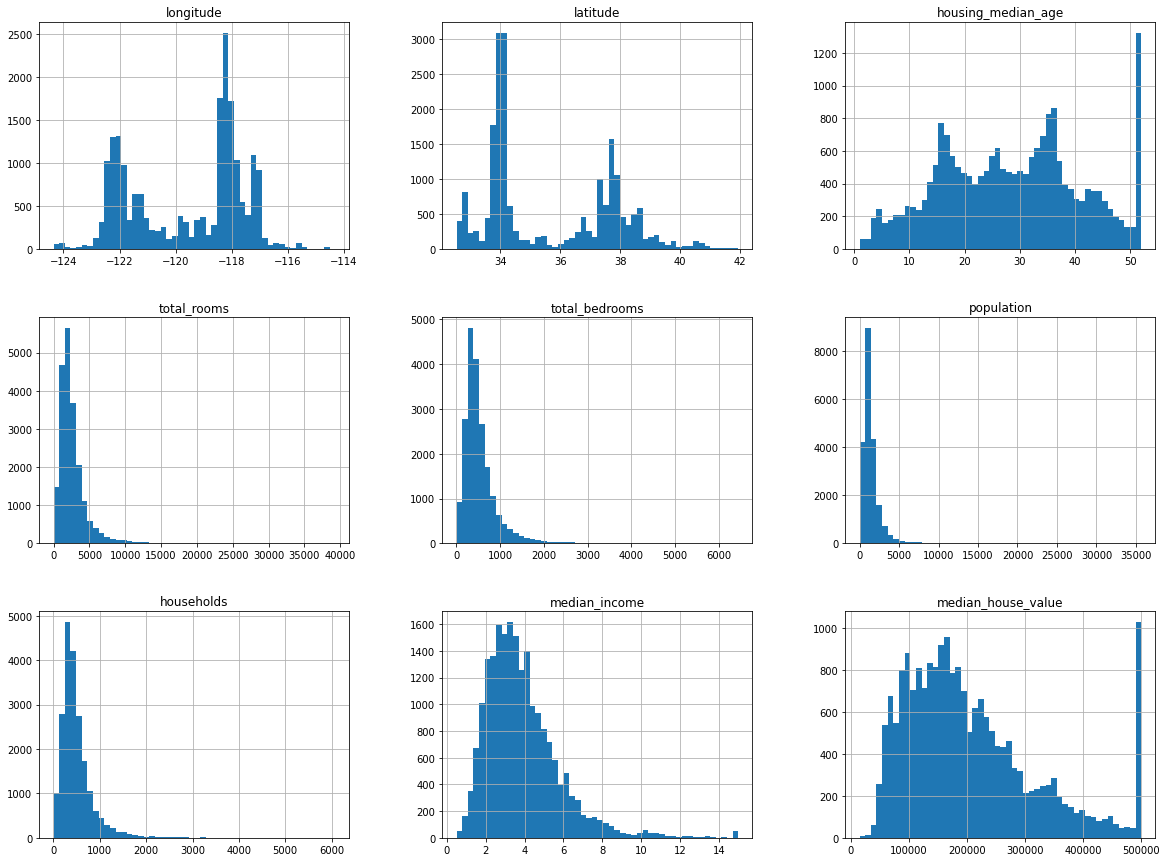

In [64]:
housing.hist(bins = 50, figsize=(20, 15))

In [65]:
def test_set_check(identifier, test_ratio, hash): 
    return hash(np.int64(identifier)).digest()[-1]< 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [66]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [67]:
housing["income_cat"] = np.ceil(housing["median_income"]/ 1.5)
housing["income_cat"].where(housing["median_income"]< 5, 5.0, inplace = True)


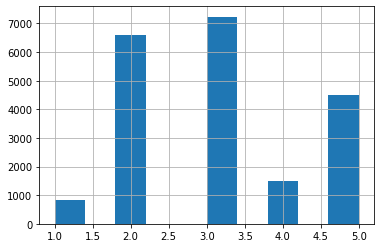

In [71]:
output_plot = housing["income_cat"].hist(bins = 10)

In [75]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]): 
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [76]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3.0    0.350533
2.0    0.318798
5.0    0.218508
4.0    0.072432
1.0    0.039729
Name: income_cat, dtype: float64

<AxesSubplot:ylabel='Density'>

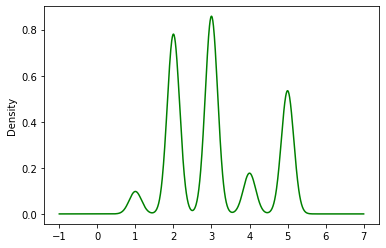

In [80]:
housing["income_cat"].plot.kde(color = "green")

In [81]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [ ]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

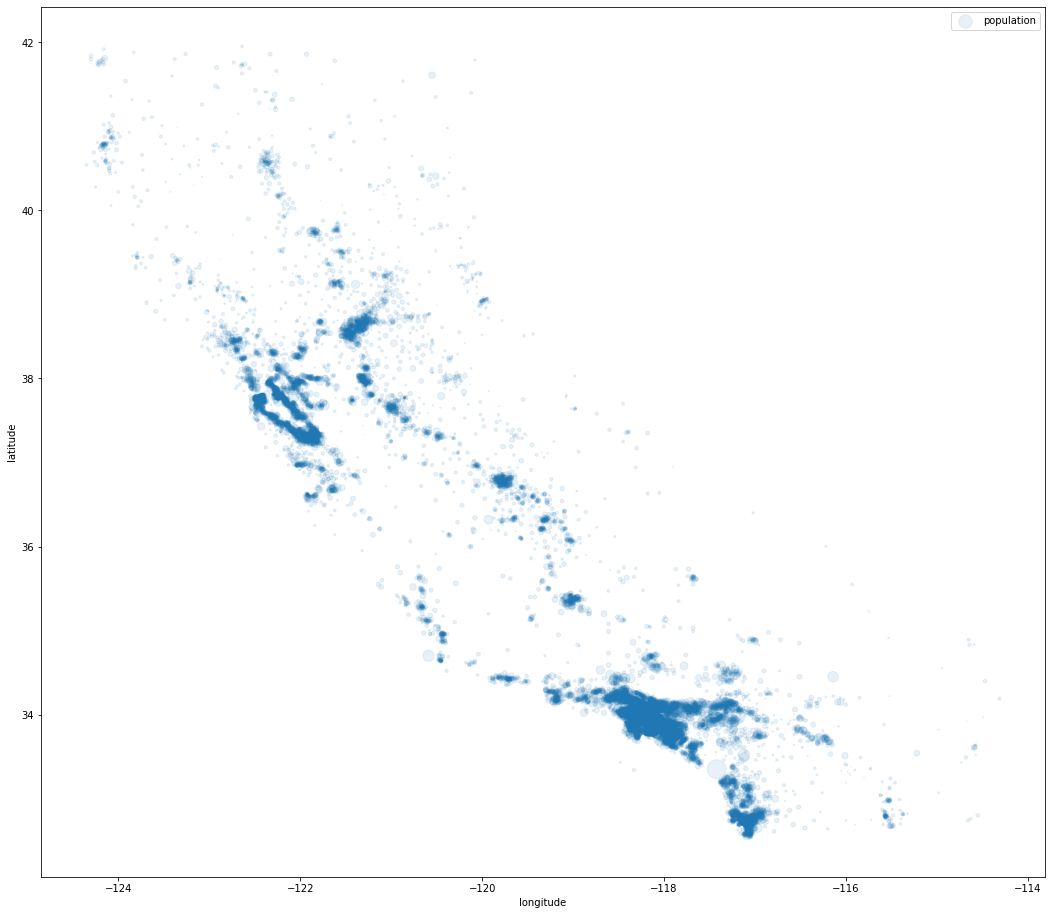

In [100]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1, 
            s = housing["population"]/100, label = "population", figsize = (18, 16))

In [101]:
corr_matrix = housing.corr()

In [102]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687752
total_rooms           0.136422
housing_median_age    0.106985
households            0.066340
total_bedrooms        0.050081
population           -0.024622
longitude            -0.047586
latitude             -0.142814
Name: median_house_value, dtype: float64

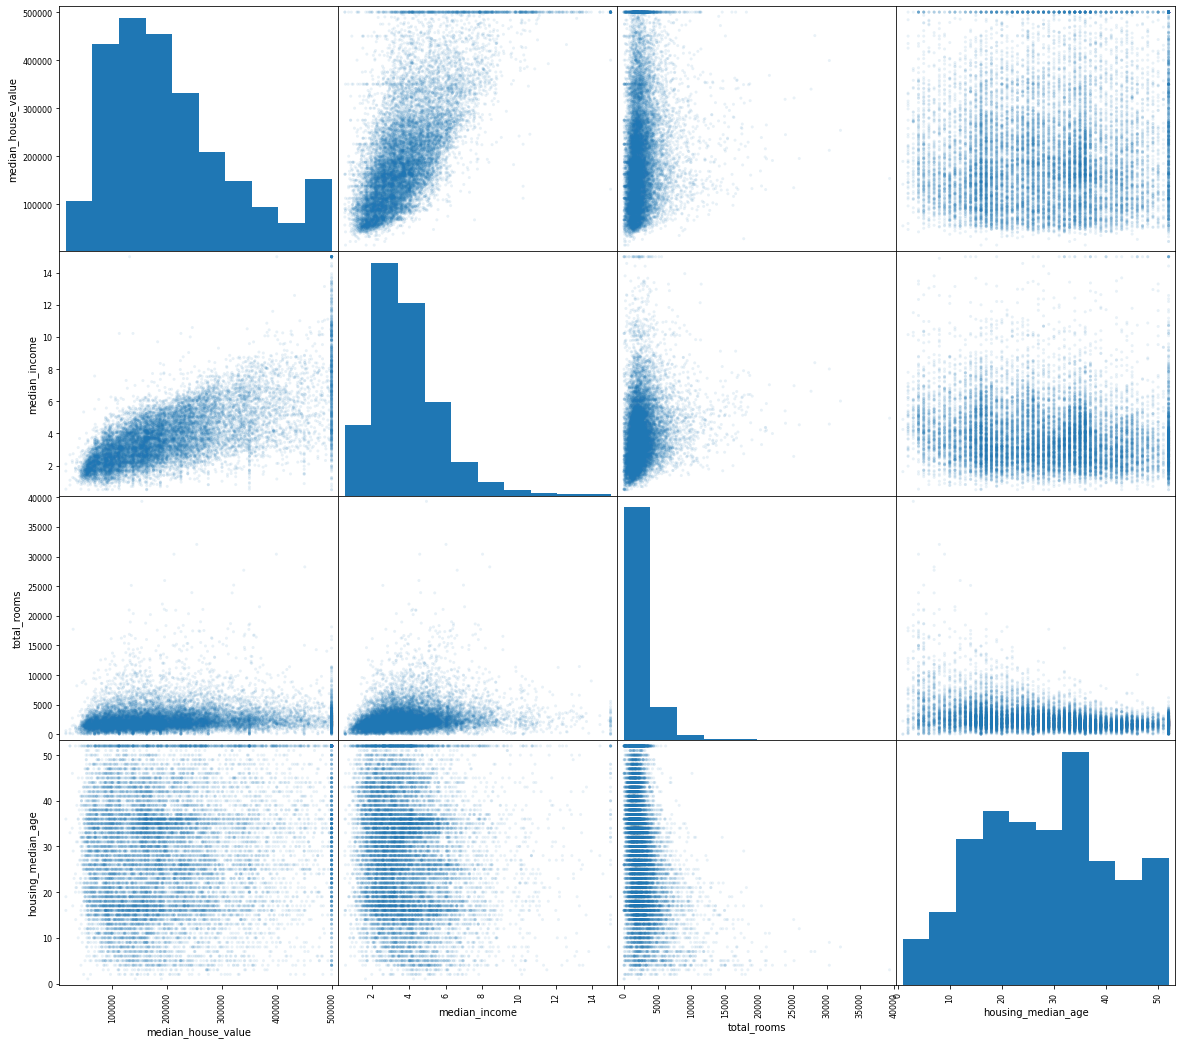

In [106]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
plot = scatter_matrix(housing[attributes], figsize=(20, 18), alpha = 0.1)

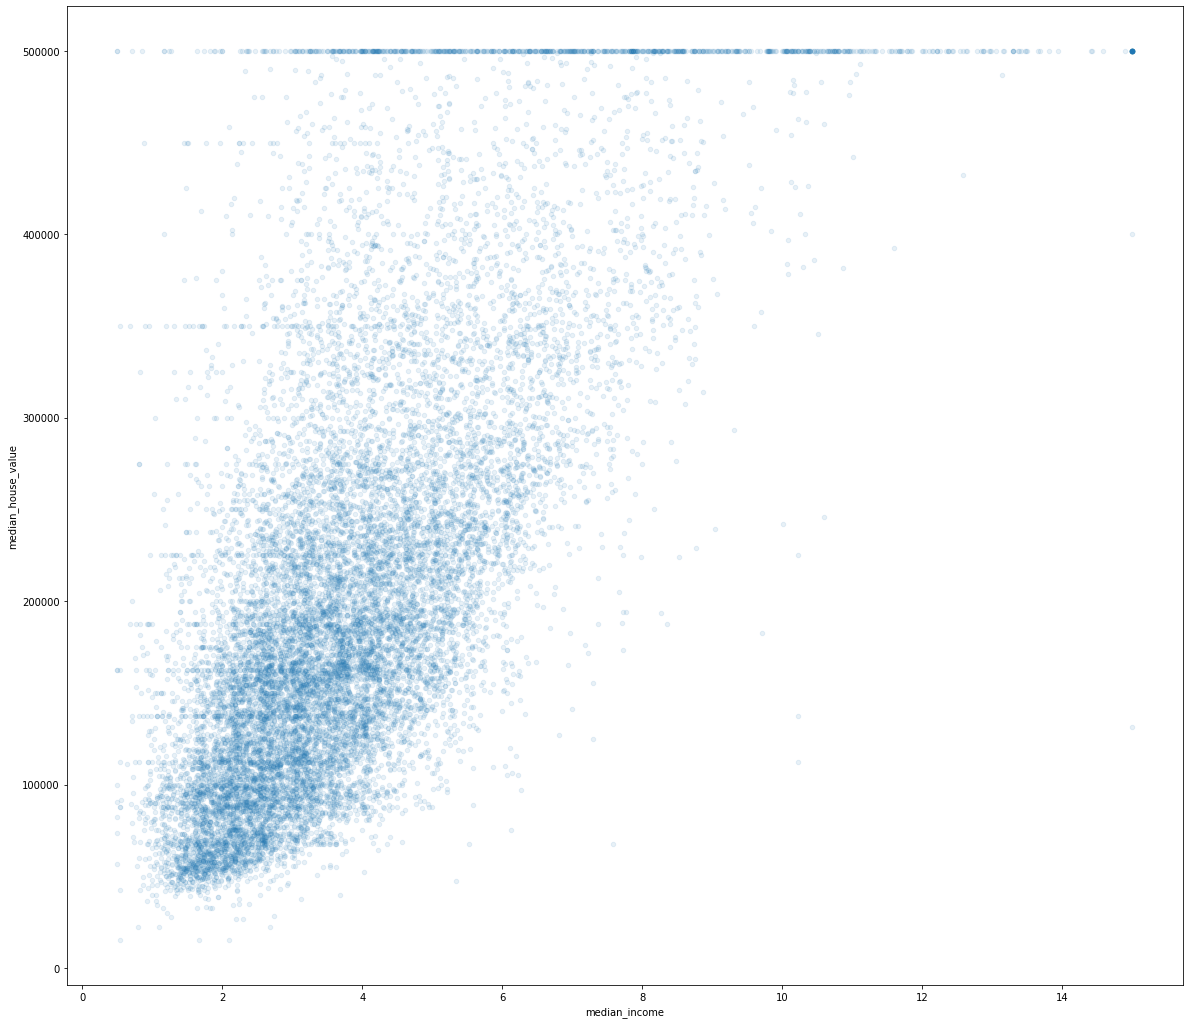

In [111]:
plot = housing.plot (kind = "scatter", x = "median_income", y = "median_house_value", figsize = (20, 18),alpha = 0.1)

In [120]:
(housing["median_house_value"]>500000).value_counts()

False    15727
True       785
Name: median_house_value, dtype: int64

In [119]:
housing["median_house_value"].describe()

count     16512.000000
mean     207172.661216
std      115800.524778
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264500.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [165]:
housing["room_per_household"] = housing["total_rooms"]/ housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [167]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687752
room_per_household          0.145300
total_rooms                 0.136422
housing_median_age          0.106985
households                  0.066340
total_bedrooms              0.050081
population_per_household   -0.022435
population                 -0.024622
longitude                  -0.047586
latitude                   -0.142814
bedrooms_per_room          -0.258861
Name: median_house_value, dtype: float64

In [168]:
housing = strat_train_set.drop ("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [172]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [175]:
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
imputer.statistics_

array([-119.57497699,   35.63710998,   28.61652132, 2626.61167636,
        535.95187427, 1422.23352713,  498.07376453,    3.87294171])

X = imputer.transform(housing_num)

In [183]:
(housing_num.isna()).value_counts()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income
False      False     False               False        False           False       False       False            16353
                                                      True            False       False       False              159
dtype: int64

<AxesSubplot:>

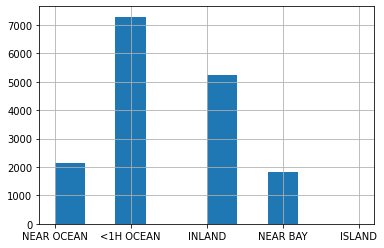

In [188]:
housing_cat = housing["ocean_proximity"]
housing_cat.hist()